<a href="https://colab.research.google.com/github/Krupa049/Fraud-Detection_PySpark-Kafka/blob/main/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("FraudDetection").getOrCreate()


In [3]:
!pip install findspark

In [4]:
!pip install confluent

In [5]:
!pip install kafka

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 4.0 MB/s eta 0:00:00


In [6]:
import findspark
findspark.init()

In [7]:
import pandas as pd
import random
import time

# Generate synthetic data

data = [
    {
        "transaction_id": i,
        "customer_id": random.randint(1, 500),
        "merchant_id": random.randint(1, 100),
        "amount": random.uniform(1.0, 500.0),
        "latitude": random.uniform(-90, 90),
        "longitude": random.uniform(-180, 180),
        "timestamp": time.time() - random.randint(0, 100000),
    }
    for i in range(10000)
]

df = pd.DataFrame(data)
df.to_csv("transactions.csv", index=False)

In [8]:
# Uploading Data to Google Colab

from google.colab import files
uploaded = files.upload()

Saving transactions.csv to transactions (1).csv


In [9]:
# LOAD DATA INTO PYSPARK
# Read CSV Data

schema = (
    "transaction_id INT, customer_id INT, merchant_id INT, "
    "amount FLOAT, latitude FLOAT, longitude FLOAT, timestamp FLOAT"
)

transactions = spark.read.csv("transactions.csv", schema=schema, header=True)
transactions.show(5)

+--------------+-----------+-----------+----------+----------+----------+------------+
|transaction_id|customer_id|merchant_id|    amount|  latitude| longitude|   timestamp|
+--------------+-----------+-----------+----------+----------+----------+------------+
|             0|        421|         41| 445.26422|  87.92966| -86.42433| 1.7317783E9|
|             1|        413|         44|114.082825| -27.42288|   80.0717|1.73169894E9|
|             2|        345|         57| 137.67874|-12.007396|  99.34418|1.73176998E9|
|             3|        262|          2|  433.7412| -43.79981| -78.92043|1.73176704E9|
|             4|        361|         16| 44.714916|  -4.83189|-108.45476|1.73175181E9|
+--------------+-----------+-----------+----------+----------+----------+------------+
only showing top 5 rows



In [10]:
# PREPROCESS DATA
# Add derived columns and clean data

from pyspark.sql.functions import col, unix_timestamp, from_unixtime

# Convert timestamp to readable format
transactions = transactions.withColumn(
    "timestamp", from_unixtime(col("timestamp"))

)

# Add transaction velocity (Dummy feature)
transactions = transactions.withColumn("transaction_velocity", col("amount") / 100)
transactions.show(5)

+--------------+-----------+-----------+----------+----------+----------+-------------------+--------------------+
|transaction_id|customer_id|merchant_id|    amount|  latitude| longitude|          timestamp|transaction_velocity|
+--------------+-----------+-----------+----------+----------+----------+-------------------+--------------------+
|             0|        421|         41| 445.26422|  87.92966| -86.42433|2024-11-16 17:31:44|   4.452642211914062|
|             1|        413|         44|114.082825| -27.42288|   80.0717|2024-11-15 19:29:04|  1.1408282470703126|
|             2|        345|         57| 137.67874|-12.007396|  99.34418|2024-11-16 15:13:04|  1.3767874145507812|
|             3|        262|          2|  433.7412| -43.79981| -78.92043|2024-11-16 14:24:00|      4.337412109375|
|             4|        361|         16| 44.714916|  -4.83189|-108.45476|2024-11-16 10:10:08|  0.4471491622924805|
+--------------+-----------+-----------+----------+----------+----------+-------

In [11]:
# FEATURE ENGINEERING
# Calculate Behavioral Features
# Using spark's window functions to create aggregated metrics

from pyspark.sql.window import Window
from pyspark.sql.functions import avg, count

# Defines a window specification for calcculating rolling metrics
window_spec = Window.partitionBy("customer_id").orderBy("timestamp").rowsBetween(-10, 0)

# Adding new columns 'avg_amount' and 'transaction_count'
transactions = transactions.withColumn(
    "avg_amount", avg("amount").over(window_spec)
).withColumn(
    "transaction_count", count("transaction_id").over(window_spec)
)

transactions.show(5)

+--------------+-----------+-----------+---------+----------+----------+-------------------+--------------------+------------------+-----------------+
|transaction_id|customer_id|merchant_id|   amount|  latitude| longitude|          timestamp|transaction_velocity|        avg_amount|transaction_count|
+--------------+-----------+-----------+---------+----------+----------+-------------------+--------------------+------------------+-----------------+
|          7162|          1|         23|200.25197|  74.79868|-18.641907|2024-11-15 20:45:52|  2.0025196838378907|200.25196838378906|                1|
|           935|          1|         92|36.233307| -84.85537|  92.37278|2024-11-15 21:41:20| 0.36233306884765626|118.24263763427734|                2|
|          7806|          1|         41| 265.6591| 39.129707|-129.58333|2024-11-15 22:56:00|   2.656590881347656|167.38145446777344|                3|
|          2779|          1|         90|157.32312|-7.5584583|-137.96658|2024-11-15 23:02:24|  

In [13]:
# ANOMALY DETECTION
# Prepare Features for Model
# Using PySpark MLlib to assemble features for modeling

from pyspark.ml.feature import VectorAssembler

# List of column names used as input features for ML
feature_cols = ["amount", "transaction_velocity", "avg_amount", "transaction_count"]

# Combines the selected feature columns into single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Creates new data frame 'features'
feature_data = assembler.transform(transactions)

In [14]:
# Trains KMeans Model
# Train an unsupervised model to detect anomalies

from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(feature_data)

# Applies the trained KMeans model to the feature data
predictions = model.transform(feature_data)
predictions.show(5)

+--------------+-----------+-----------+---------+----------+----------+-------------------+--------------------+------------------+-----------------+--------------------+----------+
|transaction_id|customer_id|merchant_id|   amount|  latitude| longitude|          timestamp|transaction_velocity|        avg_amount|transaction_count|            features|prediction|
+--------------+-----------+-----------+---------+----------+----------+-------------------+--------------------+------------------+-----------------+--------------------+----------+
|          7162|          1|         23|200.25197|  74.79868|-18.641907|2024-11-15 20:45:52|  2.0025196838378907|200.25196838378906|                1|[200.251968383789...|         0|
|           935|          1|         92|36.233307| -84.85537|  92.37278|2024-11-15 21:41:20| 0.36233306884765626|118.24263763427734|                2|[36.2333068847656...|         0|
|          7806|          1|         41| 265.6591| 39.129707|-129.58333|2024-11-15 22

In [15]:
# Filter Suspicious Transactions
# Identify transactions that are flagged as anomalies

suspicious_transactions = predictions.filter(predictions.prediction == 1)
suspicious_transactions.show(5)

+--------------+-----------+-----------+---------+----------+---------+-------------------+--------------------+------------------+-----------------+--------------------+----------+
|transaction_id|customer_id|merchant_id|   amount|  latitude|longitude|          timestamp|transaction_velocity|        avg_amount|transaction_count|            features|prediction|
+--------------+-----------+-----------+---------+----------+---------+-------------------+--------------------+------------------+-----------------+--------------------+----------+
|          8615|          1|         40|338.39337|-18.772503|-22.77183|2024-11-16 01:38:08|  3.3839337158203127|192.17849731445312|                6|[338.393371582031...|         1|
|          7377|          1|         15| 385.6877| 40.744034|-73.63942|2024-11-16 06:13:20|  3.8568771362304686|212.92520989312067|                9|[385.687713623046...|         1|
|          4141|          1|         34|447.17673| 17.509811|-83.39038|2024-11-16 10:01:36

In [27]:
# SAVING AND ANALYZING RESULTS
# Save Results Locally


from pyspark.sql.functions import col

# Convert 'features' column to a string
cleaned_data = suspicious_transactions.withColumn("features", col("features").cast("string"))
cleaned_data.write.csv("suspicious_transactions.csv", mode="overwrite", header=True)

In [28]:
from google.colab import files
files.download("suspicious_transactions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

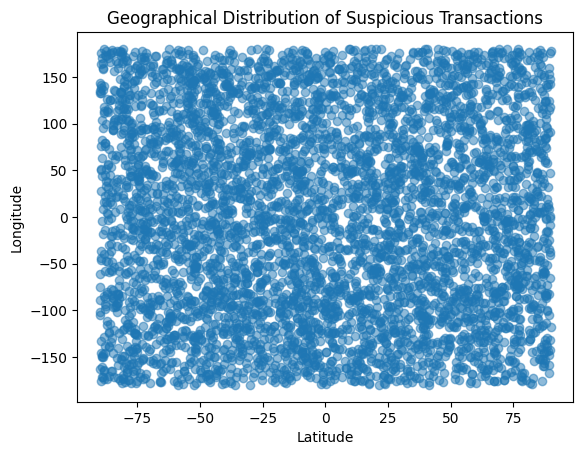

In [29]:
# DATA VISUALIZATION
# Exporting Data for Visualization
suspicious_df = suspicious_transactions.toPandas()

import matplotlib.pyplot as plt

# Plotting Insights in Colab
plt.scatter(suspicious_df["latitude"], suspicious_df["longitude"], alpha=0.5)
plt.title("Geographical Distribution of Suspicious Transactions")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()